In [13]:
import couchdb
import json
import time
# from couchdb_settings import *

username = 'admin'
password = '123456'
address = 'localhost:15984'

testdb = couchdb.Database('http://' + address + '/view-test')
testdb.resource.credentials = (username, password)

languages = dict()

for item in testdb.view('geo-test/lang-count', group = True, group_level = 1):
    languages[item.key] = item.value
    languages = {k: v for k, v in sorted(languages.items(), key=lambda item: item[1])[::-1]}



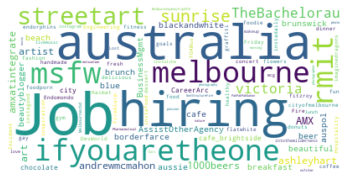

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

threshold = 5

hashtags = []

for item in testdb.view('geo-test/hash-tags', group = True, group_level = 1):
    if item.value >= threshold:
        hashtags.append(item.key)

string = ','.join(hashtags)

wc = WordCloud(background_color="white", max_words=100)

plt.imshow(wc.generate(string), interpolation='bilinear')
plt.axis("off")
plt.show()
